In [1]:
import matplotlib.pyplot as plt
import random
import math
from tqdm import tqdm

# Funkcje pomocnicze:

In [2]:
def cost_all(image, cost_singular):
    n = len(image)
    return sum([cost_singular(image, x, y) for x in range(n) for y in range(n)])

def acceptance_probability(old_cost, new_cost, T):
    if new_cost < old_cost:
        return 1.0
    else:
        return math.exp(-abs(new_cost - old_cost) / T)

def temp(T):
    return T * 0.9998

#funkcja do oszacowania górnej granicy liczby iteracji
def total_count(T, temp_fun, min_temp):
    a = 1
    while T > min_temp:
        T = temp_fun(T)
        a += 1
    return a

# Funkcje do rysowania:

In [3]:
def plot_costs(costs):
    plt.plot([cost for cost in costs])
    plt.show()

In [45]:
def plot_image(bin_image, size=5, size2=5, same_size=True):
    if same_size:
        fig = plt.figure(figsize=(size, size))
    else:
        fig = plt.figure(figsize=(size, size2))
    ax = fig.add_subplot(111)
    ax.matshow(bin_image, aspect="auto")
    plt.show()
#     plt.imshow(bin_image)
#     plt.show()

# Funkcje energii:

## Szachownica (4 elementy brane pod uwagę):

In [5]:
def cost_4_elem(image, i, j):
    n = len(image)
    val = image[i][j]
    values = [image[(i + 1) % n][j], image[(i - 1) % n][j], image[i][(j + 1) % n], image[i][(j - 1) % n]]
    return sum(map(lambda x : 1 if val == x else 0, values))

### Porządane ustawienia:
zielone kwadraty nie są brane pod uwagę

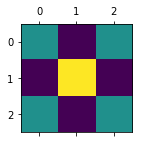

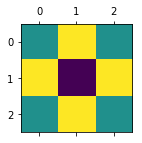

In [6]:
plot_image([[0.5,0,0.5],[0,1,0], [0.5,0,0.5]], size=2)
plot_image([[0.5,1,0.5],[1,0,1], [0.5,1,0.5]], size=2)

## Takie same punkty (8 elementów branych pod uwagę)

Zminimalizowanie energii dla tej funkcji polega zgrupowaniu elementów podobnych do siebie

In [7]:
def cost_8_elem(image, i, j):
    n = len(image)
    val = image[i][j]
    values = [image[(x + i) % n][(y + j) % n] for x in range(-1, 2) for y in range(-1,2) if (x,y) != (0,0)]
    return sum(map(lambda x : 0 if val == x else 1, values))

# Pionowe zależności (10 elementów branych pod uwagę)

Zminimalizowanie energii dla tej funkcji polega na zgrupowaniu takich samych elementów w linie

In [8]:
def cost_10_elem(image, i, j):
    n = len(image)
    val = image[i][j]
    values = [image[(x + i) % n][j] for x in range(-4, 4) if x != 0]
    values2 = [image[i][(j-1) % n], image[i][(j+1)%n]]
    return sum(map(lambda x : 0 if val == x else 1, values)) + sum(map(lambda x : 1 if val == x else 0, values2))

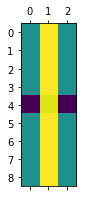

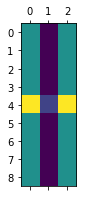

In [53]:
plot_image([[0.5,1,0.5], [0.5,1,0.5], [0.5,1,0.5], [0.5,1,0.5], [0,0.95,0], [0.5,1,0.5], [0.5,1,0.5], [0.5,1,0.5], [0.5,1,0.5]], 1, 3, False)
plot_image([[0.5,0,0.5], [0.5,0,0.5], [0.5,0,0.5], [0.5,0,0.5], [1,0.2,1], [0.5,0,0.5], [0.5,0,0.5], [0.5,0,0.5], [0.5,0,0.5]], 1, 3, False)

# Funkcja zamiany 2 elementów i wyliczenia różnicy kosztów

In [10]:
def change(bin_image, unit_cost, significant_elements, number_of_elem):
    n = len(bin_image)
    points = [(random.randint(0,n-1), random.randint(0,n-1)) for _ in range(number_of_elem)]
    x = random.randint(0,n-1), random.randint(0,n-1)
    y = random.randint(0,n-1), random.randint(0,n-1)

    def significant_points(elements, element):
        return {((element[0] + i) % n, (element[1] + j) % n) for i,j in elements + [(0,0)]}
    
    influenced = significant_points(significant_elements, x) | significant_points(significant_elements, y)
    
    old_cost = sum([unit_cost(bin_image, point[0], point[1]) for point in influenced])

    bin_image[x[0]][x[1]], bin_image[y[0]][y[1]] = bin_image[y[0]][y[1]], bin_image[x[0]][x[1]]    
    new_cost = sum([unit_cost(bin_image, point[0], point[1]) for point in influenced])
    bin_image[x[0]][x[1]], bin_image[y[0]][y[1]] = bin_image[y[0]][y[1]], bin_image[x[0]][x[1]]
    
    return x,y, new_cost - old_cost

# Symulowane wyżarzanie

In [11]:
def sim_anneal(image, change_fun, cost_singular, significant_elements, cost_fun=cost_all, temp_fun=temp,
               acceptance_probability_fun=acceptance_probability, T=10000, min_temp=1e-8, simultanous_element_change=1):
    
    costs = []
    best_res = list([list(x) for x in image])
    curr_cost = cost_fun(image, cost_singular)
    best_cost = curr_cost
    count = 0
    
    progress_bar = tqdm(total=total_count(T, temp_fun, min_temp))
    while T > min_temp and count < 2000:
        progress_bar.update(1)
        T = temp_fun(T)
        x, y, change_cost = change_fun(image, cost_singular, significant_elements, simultanous_element_change)
        if(random.random() < acceptance_probability_fun(curr_cost, curr_cost + change_cost, T)):
            if change_cost != 0:
                count = 0
            image[x[0]][x[1]], image[y[0]][y[1]] = image[y[0]][y[1]], image[x[0]][x[1]]
            curr_cost += change_cost

            if(curr_cost < best_cost):
                best_res = list([list(x) for x in image])
                best_cost = curr_cost
        else:
            count += 1
        costs.append(curr_cost)
    progress_bar.close()
    return best_res, costs

# Generator:

In [12]:
def generate_bin_image(n, density=0.5):
    return [[0 if random.random() < density else 1 for j in range(n)] for i in range(n)]

# Tests:

## Szachownica:

### rozmiar obrazka: 10x10

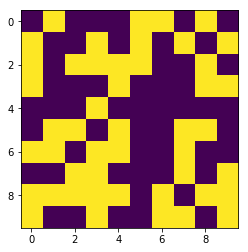

In [37]:
bin_image = generate_bin_image(10)
plot_image(bin_image)

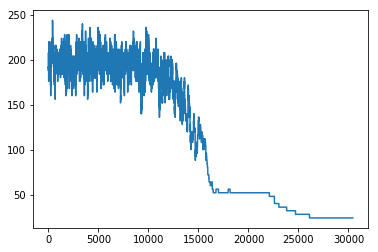

In [38]:
best, costs = sim_anneal(bin_image, change, cost_4_elem, significant_elements=[(-1,0), (1,0), (0,-1), (0,1)],temp_fun=lambda x : x * 0.9996, T=1000, min_temp=1e-8)
plot_costs(costs)

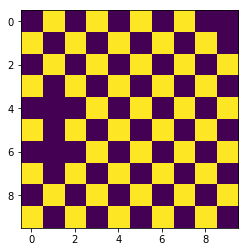

In [39]:
plot_image(best)

### Rozmiar obrazka 100x100:

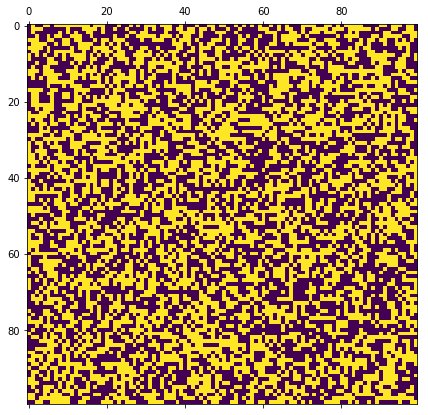

In [26]:
bin_image = generate_bin_image(100)
plot_image(bin_image, 7)

100%|█████████▉| 138142/138143 [00:12<00:00, 11383.88it/s]


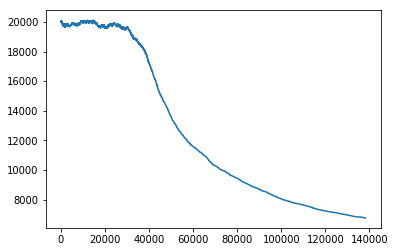

In [27]:
best, costs = sim_anneal(bin_image, change, cost_4_elem, significant_elements=[(-1,0), (1,0), (0,-1), (0,1)],temp_fun=lambda x : x * 0.9998, T=10000, min_temp=1e-8)
plot_costs(costs)

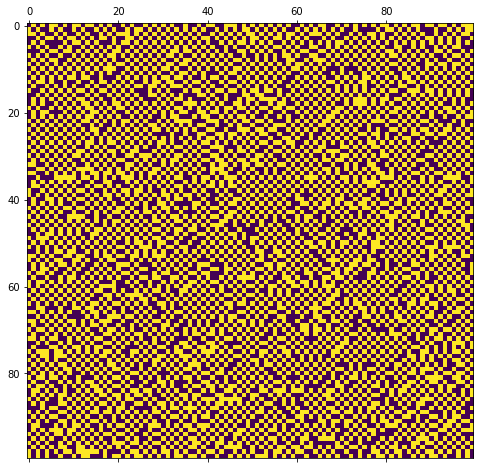

In [28]:
plot_image(best, size=8)

Jak można łatwo zauważyć na wykresie funkcji kosztów zarówno funkcja zmiany temperatury, temperatura jak i temperatura stopu nie zostały tutaj wystarczająco dobrze dobrane, przez co efekt końcowy nie jest najlepszy.

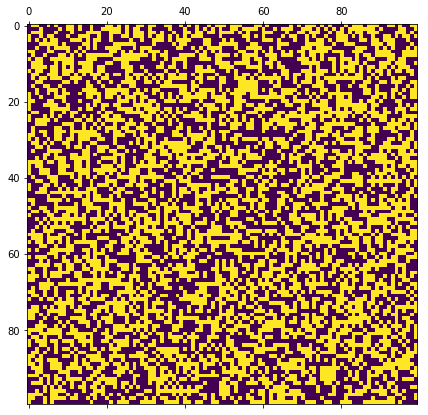

In [54]:
bin_image = generate_bin_image(100)
plot_image(bin_image, size=7)

 48%|████▊     | 534010/1105215 [00:41<00:44, 12784.98it/s]


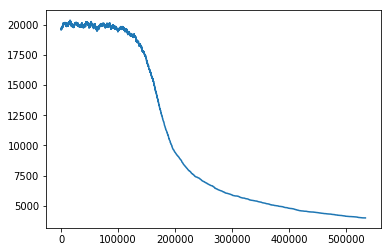

In [55]:
best, costs = sim_anneal(bin_image, change, cost_4_elem, significant_elements=[(-1,0), (1,0), (0,-1), (0,1)],temp_fun=lambda x : x * 0.99995, T=10000, min_temp=1e-20)
plot_costs(costs)

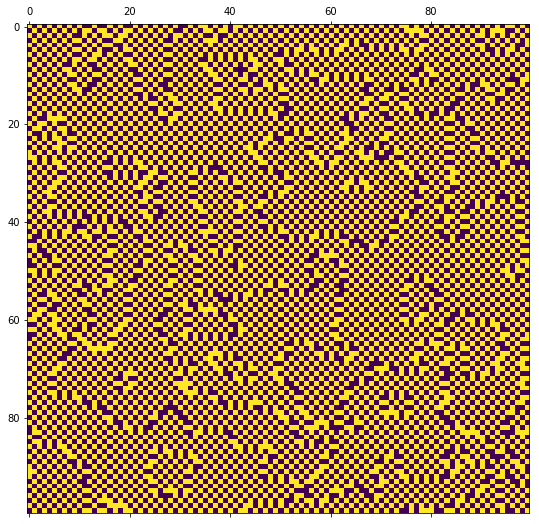

In [57]:
plot_image(best, size=9)

### Rozmiar obrazka: 100x100
#### Procent czarnych: 0.3

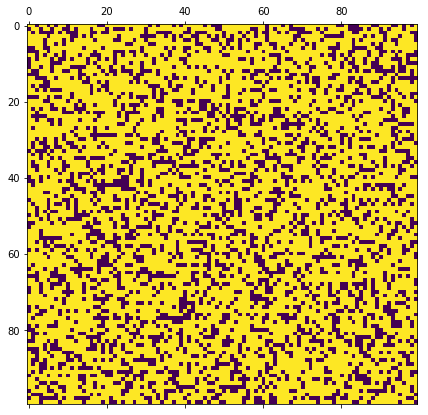

In [58]:
bin_image = generate_bin_image(100, 0.3)
plot_image(bin_image, size=7)

 26%|██▌       | 281890/1105215 [00:19<00:57, 14369.30it/s]


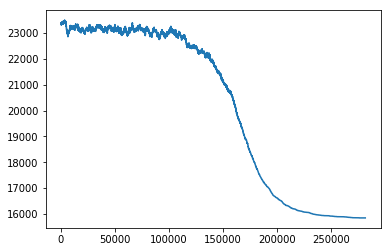

In [59]:
best, costs = sim_anneal(bin_image, change, cost_4_elem, significant_elements=[(-1,0), (1,0), (0,-1), (0,1)],temp_fun=lambda x : x * 0.99995, T=10000, min_temp=1e-20)
plot_costs(costs)

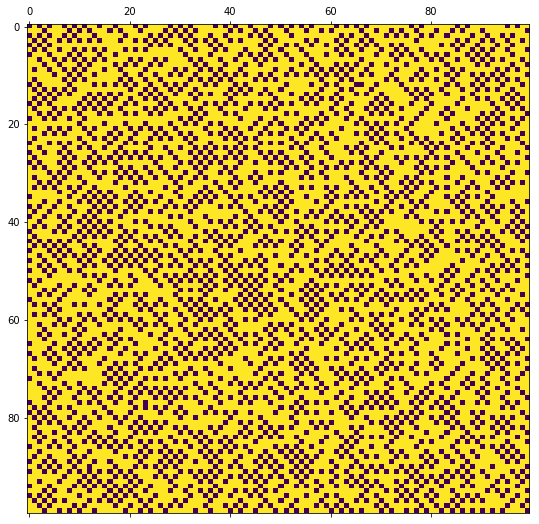

In [60]:
plot_image(best, size=9)

### Rozmiar obrazka: 512x512

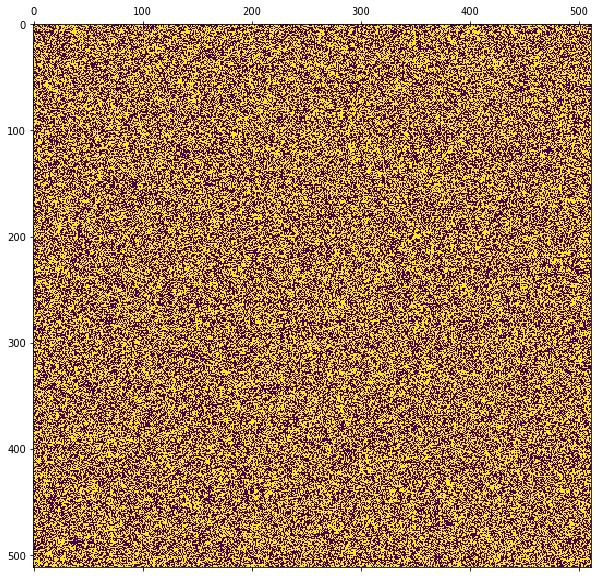

In [61]:
bin_image = generate_bin_image(512)
plot_image(bin_image, size=10)

 63%|██████▎   | 6964946/11052382 [11:45<06:54, 9868.38it/s] 


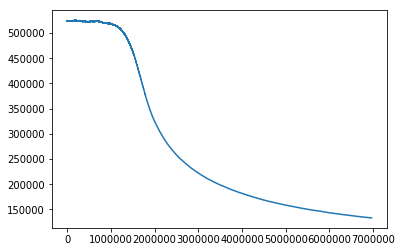

In [62]:
best, costs = sim_anneal(bin_image, change, cost_4_elem, significant_elements=[(-1,0), (1,0), (0,-1), (0,1)],temp_fun=lambda x : x * 0.999995, T=10000, min_temp=1e-20)
plot_costs(costs)

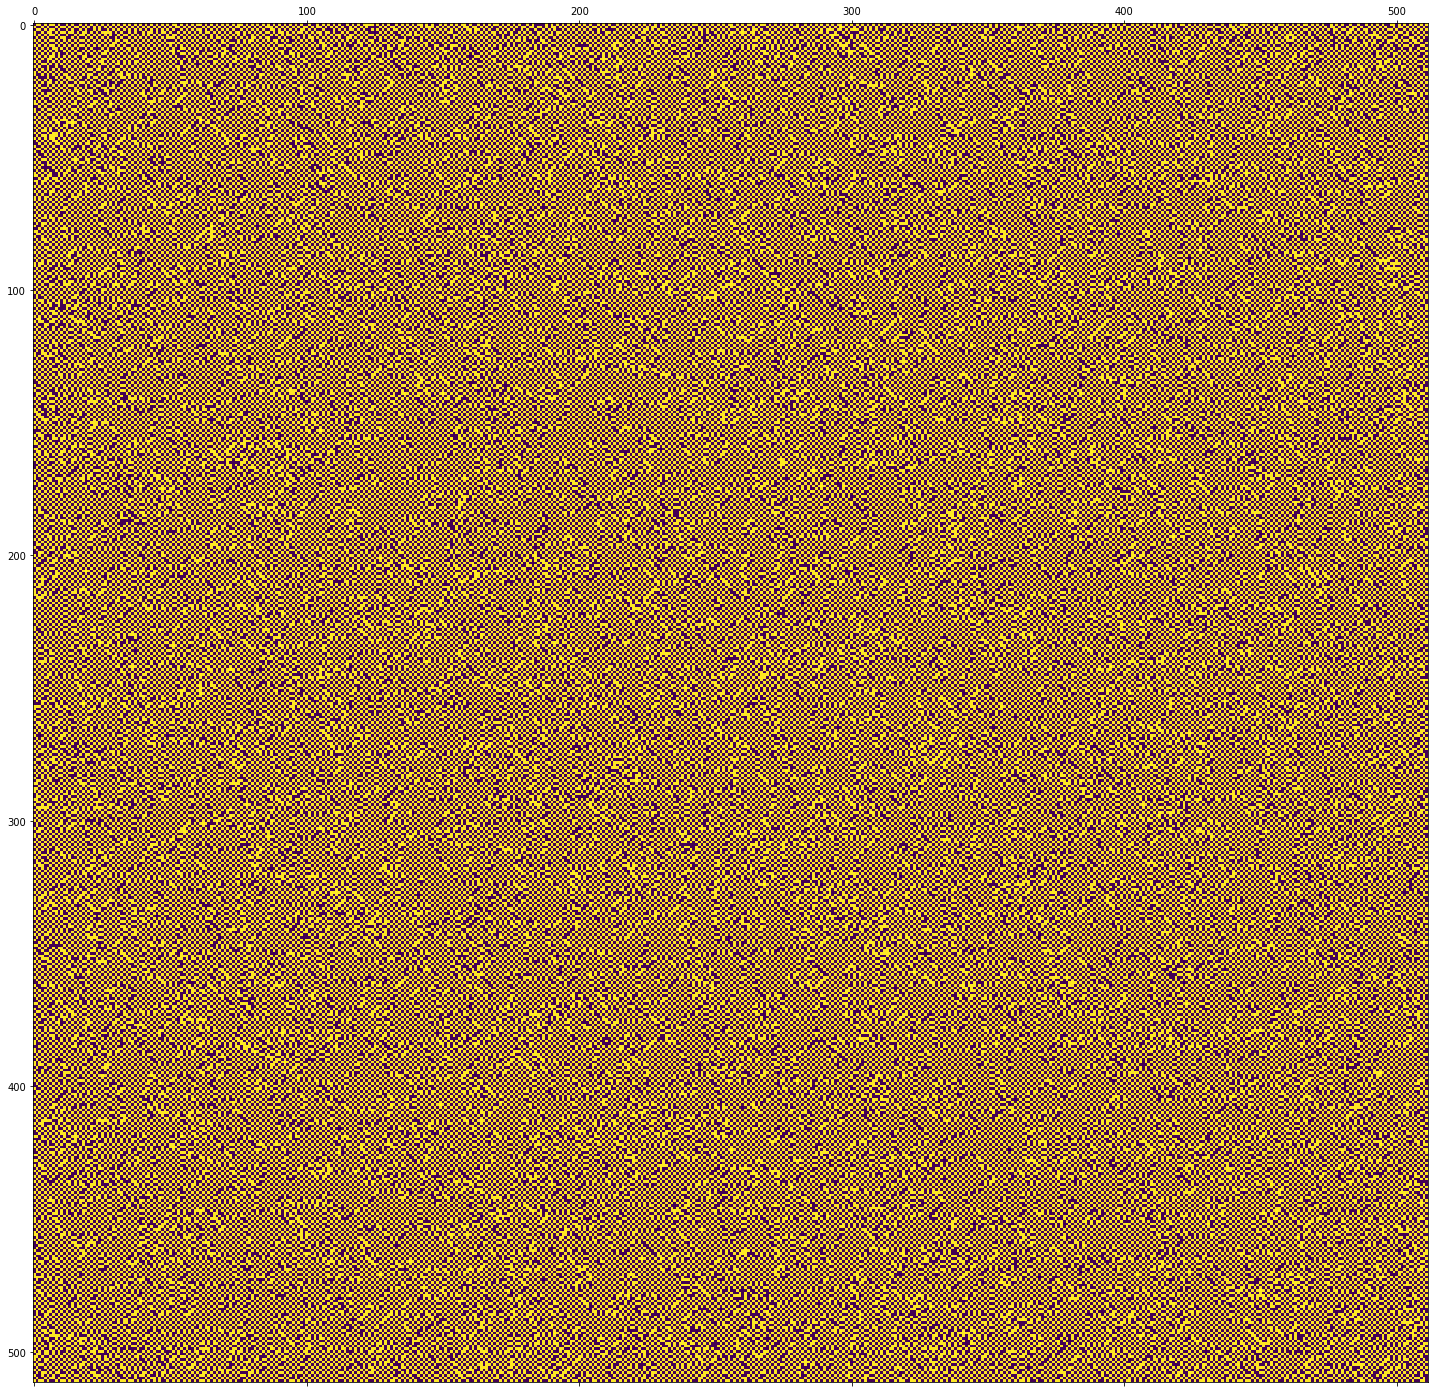

In [63]:
plot_image(best, size=25)

## zbieżność elementów:

### Rozmiar obrazka: 30x30

#### Procent czarnych elementów: 0.5

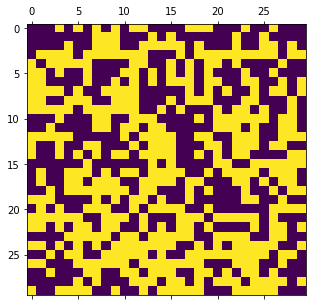

In [23]:
bin_image = generate_bin_image(30)
plot_image(bin_image)

 54%|█████▍    | 74749/138143 [00:28<00:24, 2590.96it/s]


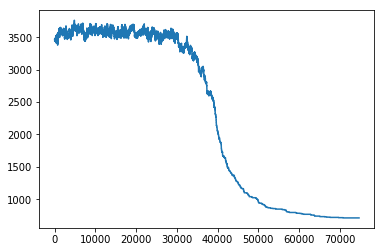

In [24]:
significant_elements = [(x,y) for x in range(-1, 2) for y in range(-1,2) if (x,y) != (0,0)]
best, costs = sim_anneal(bin_image, change, cost_8_elem, significant_elements=significant_elements,temp_fun=lambda x : x * 0.9998, T=10000, min_temp=1e-8)
plot_costs(costs)

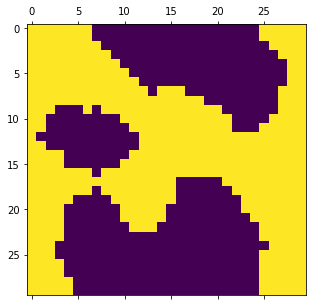

In [25]:
plot_image(best)

#### procent czarnych elementów: 0.2:

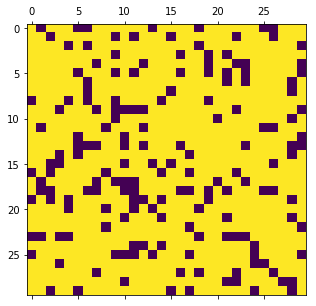

In [32]:
bin_image = generate_bin_image(30, 0.2)
plot_image(bin_image)

 64%|██████▍   | 88692/138143 [00:28<00:15, 3140.53it/s]


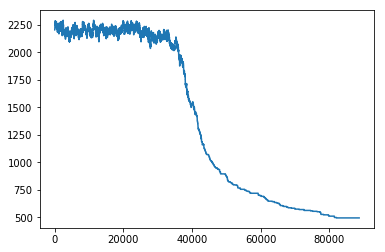

In [33]:
significant_elements = [(x,y) for x in range(-1, 2) for y in range(-1,2) if (x,y) != (0,0)]
best, costs = sim_anneal(bin_image, change, cost_8_elem, significant_elements=significant_elements,temp_fun=lambda x : x * 0.9998, T=10000, min_temp=1e-8)
plot_costs(costs)

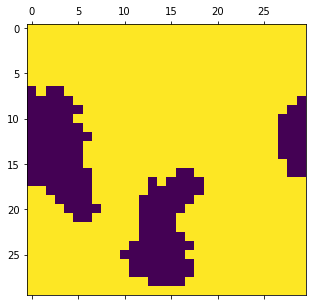

In [34]:
plot_image(best)

#### Rozmiar obrazka: 200x200
#### Procent czarnych elementów: 0.8

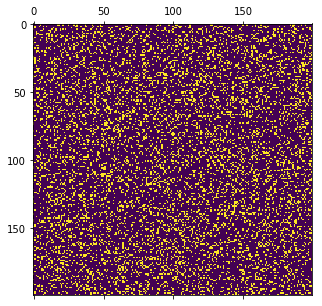

In [38]:
bin_image = generate_bin_image(200, 0.8)
plot_image(bin_image)

100%|█████████▉| 1381538/1381539 [07:35<00:00, 3033.97it/s]


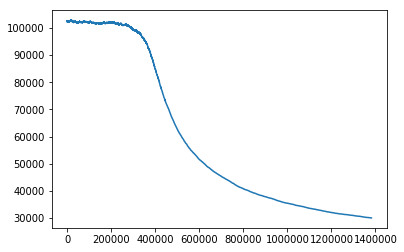

In [39]:
significant_elements = [(x,y) for x in range(-1, 2) for y in range(-1,2) if (x,y) != (0,0)]
best, costs = sim_anneal(bin_image, change, cost_8_elem, significant_elements=significant_elements,temp_fun=lambda x : x * 0.99998, T=10000, min_temp=1e-8)
plot_costs(costs)

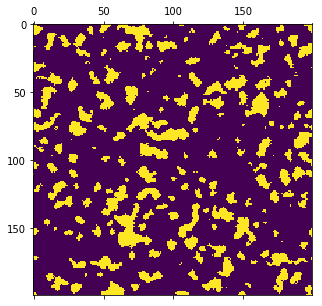

In [40]:
plot_image(best)

#### Rozmiar obrazka: 200x200
#### Procent czarnych elementów: 0.2

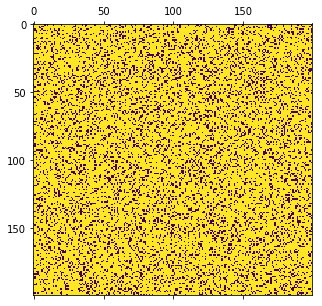

In [64]:
bin_image = generate_bin_image(200, 0.2)
plot_image(bin_image)

100%|█████████▉| 1381538/1381539 [07:18<00:00, 3150.97it/s]


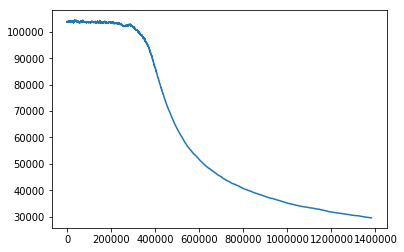

In [65]:
significant_elements = [(x,y) for x in range(-1, 2) for y in range(-1,2) if (x,y) != (0,0)]
best, costs = sim_anneal(bin_image, change, cost_8_elem, significant_elements=significant_elements,temp_fun=lambda x : x * 0.99998, T=10000, min_temp=1e-8)
plot_costs(costs)

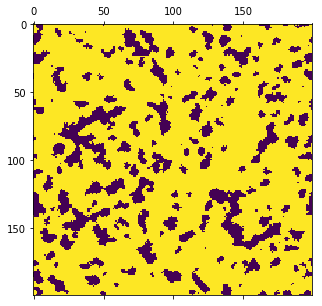

In [66]:
plot_image(best)

#### Rozmiar obrazka: 512x512

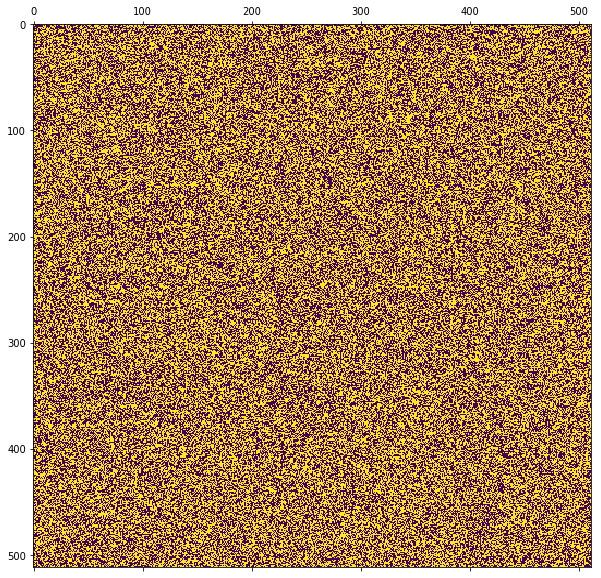

In [26]:
bin_image = generate_bin_image(512)
plot_image(bin_image, size=10)

100%|█████████▉| 2072306/2072307 [13:38<00:00, 2531.95it/s]


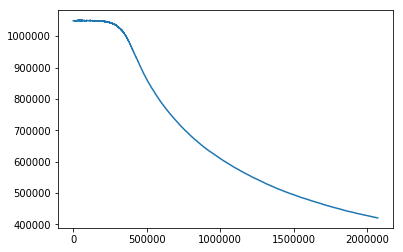

In [27]:
significant_elements = [(x,y) for x in range(-1, 2) for y in range(-1,2) if (x,y) != (0,0)]
best, costs = sim_anneal(bin_image, change, cost_8_elem, significant_elements=significant_elements,temp_fun=lambda x : x * 0.99998, T=10000, min_temp=1e-14)
plot_costs(costs)

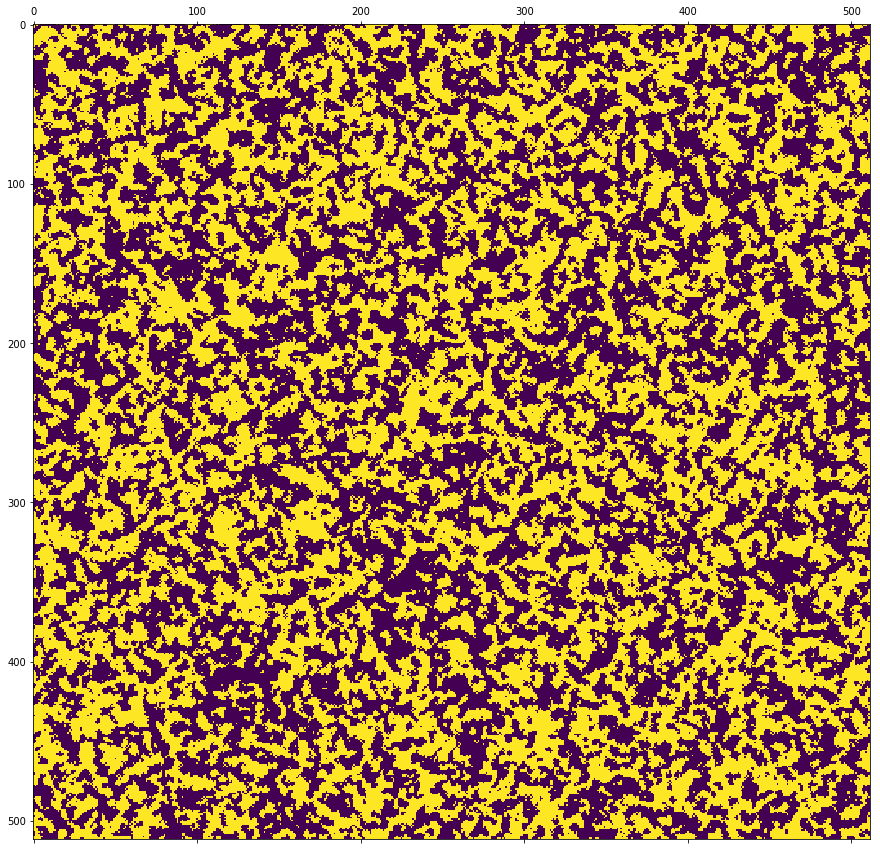

In [28]:
plot_image(best, size=15)

# Koszt 10 elementów (naprzemienny pionowy koszt)

#### Rozmiar obrazka: 20x20

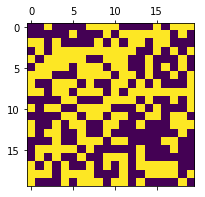

In [29]:
bin_image = generate_bin_image(20)
plot_image(bin_image, size=3)

 45%|████▍     | 68401/153496 [00:18<00:23, 3666.69it/s]


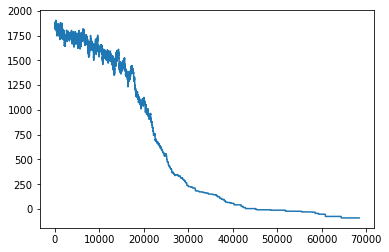

In [30]:
significant_elements = [(x,0) for x in range(-4,4) if x != 0] + [(0,-1), (0,1)] 
best, costs = sim_anneal(bin_image, change, cost_10_elem, significant_elements=significant_elements,temp_fun=lambda x : x * 0.99985, T=100, min_temp=1e-8)
plot_costs(costs)

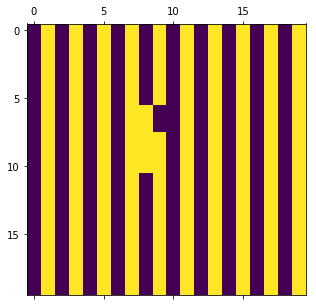

In [31]:
plot_image(best, size = 5)

#### Rozmiar obrazka 30x30:
#### Procent czarnych elementów: 0.3:

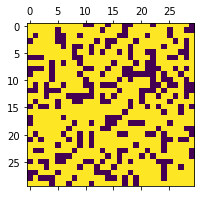

In [41]:
bin_image = generate_bin_image(30, 0.3)
plot_image(bin_image, size=3)

 52%|█████▏    | 79998/153496 [00:23<00:21, 3347.93it/s]


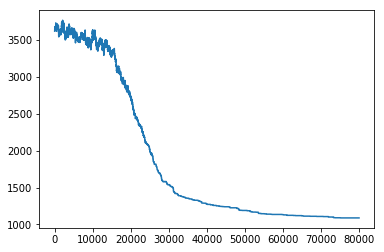

In [42]:
significant_elements = [(x,0) for x in range(-4,4) if x != 0] + [(0,-1), (0,1)] 
best, costs = sim_anneal(bin_image, change, cost_10_elem, significant_elements=significant_elements,temp_fun=lambda x : x * 0.99985, T=100, min_temp=1e-8)
plot_costs(costs)

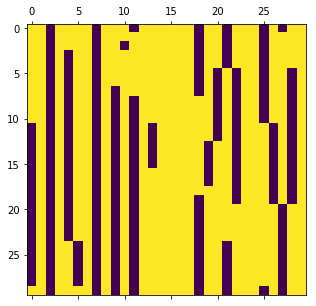

In [43]:
plot_image(best, size = 5)

#### Rozmiar obrazka: 100x100

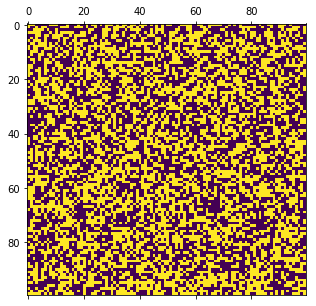

In [32]:
bin_image = generate_bin_image(100)
plot_image(bin_image)

 98%|█████████▊| 630588/644709 [02:58<00:03, 3541.31it/s]


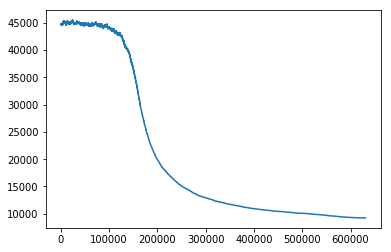

In [33]:
significant_elements = [(x,0) for x in range(-4,4) if x != 0] + [(0,-1), (0,1)] 
best, costs = sim_anneal(bin_image, change, cost_10_elem, significant_elements=significant_elements,temp_fun=lambda x : x * 0.99995, T=10000, min_temp=1e-10)
plot_costs(costs)

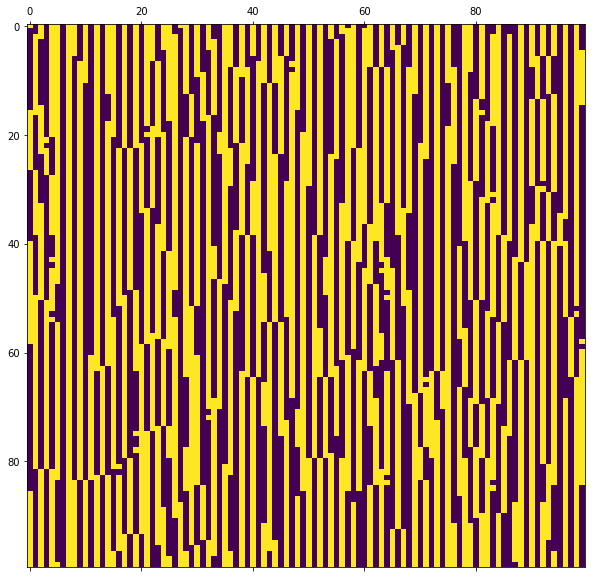

In [34]:
plot_image(best, size = 10)

#### Rozmiar obrazka: 512x512

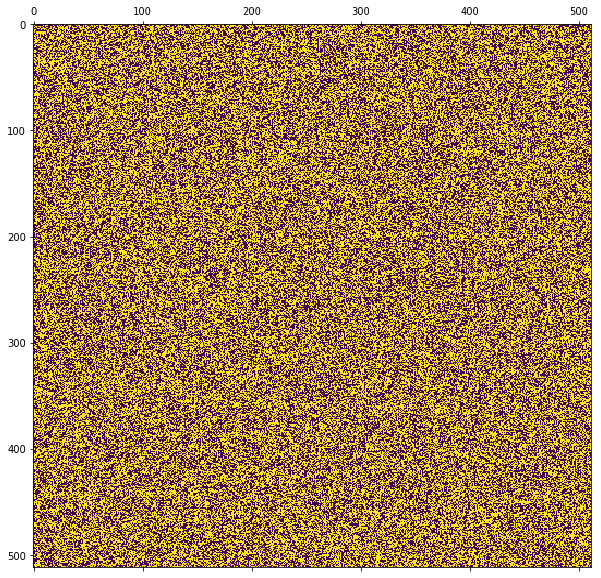

In [17]:
bin_image = generate_bin_image(512)
plot_image(bin_image, 10)

In [15]:
i = 0
T = 10000
while T>1e-14:
    T = T*0.999995
    i += 1
i

8289286

100%|█████████▉| 8289286/8289287 [54:16<00:00, 2545.25it/s]  


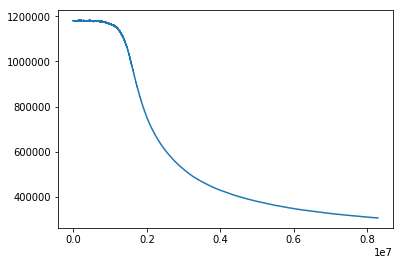

In [18]:
significant_elements = [(x,0) for x in range(-4,4) if x != 0] + [(0,-1), (0,1)] 
best, costs = sim_anneal(bin_image, change, cost_10_elem, significant_elements=significant_elements,temp_fun=lambda x : x * 0.999995, T=10000, min_temp=1e-14)
plot_costs(costs)

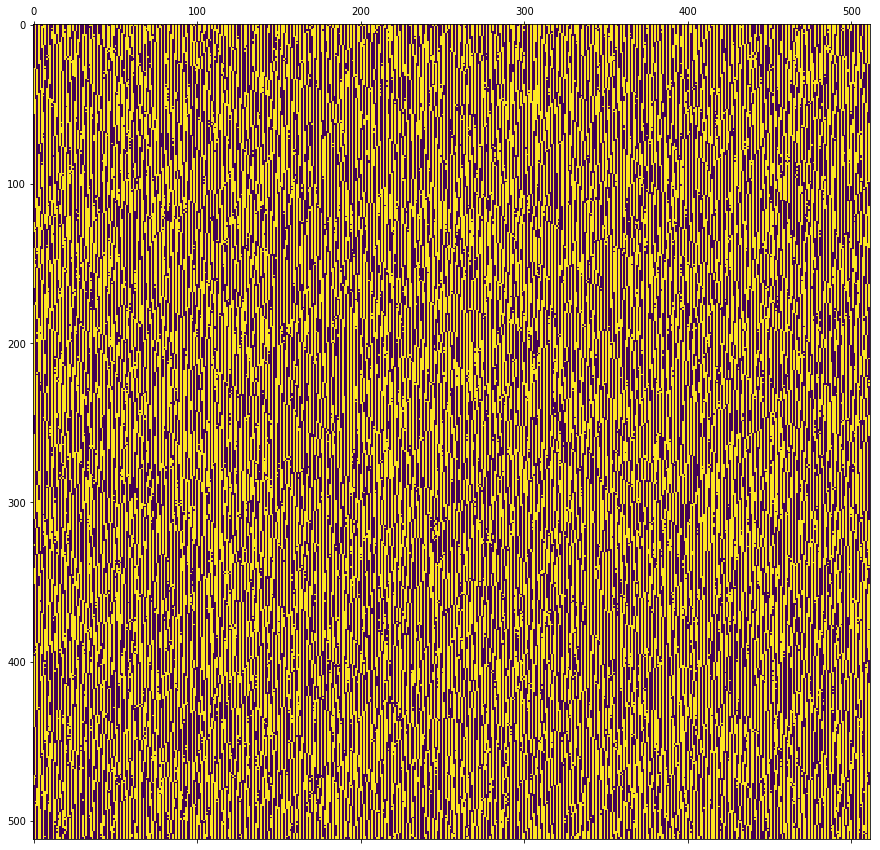

In [19]:
plot_image(best, size = 15)